In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
import os
import pickle as pk
import numpy as np
import pandas as pd
from phys.phys_utils import nnan_pearsonr as nnan_pearsonr
from phys import data_utils, phys_utils
# from rnn_analysis import utils as rnn_analysis_utils
# from rnn_analysis import utils as analysis_utils
from phys.plot_scripts import generic_plot_utils as rr_gpu
from phys.plot_scripts import decoding_summary as dec_plots
from phys.plot_scripts import rnn_comparisons_2021 as rnn_plots
from sklearn.decomposition import PCA, FastICA, FactorAnalysis

/Users/hansem/Dropbox (MIT)/MPong/phys/plot_scripts/decoding_summary.py:57: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  preproc_suffix = '_%s%d' % (self.preprocess_func, self.ncomp) if self.preprocess_func is not 'none' else ''


In [3]:
figoutpath_base = '/Users/hansem/Dropbox (MIT)/MPong/figs/mpong_phys/redo_paper_scratch_202202' # '/om/user/rishir/figs/mpong_phys/paper_scratch_202202/'

# are factors representing task variables?

In [4]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [5]:
def load_neural_data_base(subject_id, mask_fn, 
                          condition='occ', 
                          neural_data_to_use='neural_responses_reliable_FactorAnalysis_20'):
    neural_data = data_utils.load_neural_dataset(subject_id=subject_id, timebinsize=50, recompute_augment=False)

    condition = 'occ'
    beh_to_decode = ['ball_pos_x_TRUE', 'ball_pos_y_TRUE', 'ball_pos_dx_TRUE', 'ball_pos_dy_TRUE',
                    't_from_start', 't_from_occ', 't_from_end']

    mask_fn_neur = mask_fn_beh = mask_fn
    mask_neur_cxt = np.array(neural_data['masks'][condition][mask_fn_neur])
    mask_beh_cxt = np.array(neural_data['masks'][condition][mask_fn_beh])

    data_neur_nxcxt = np.array(neural_data[neural_data_to_use][condition])
    data_beh_bxcxt = np.array([neural_data['behavioral_responses'][condition][fk] for fk in beh_to_decode])

    data = {
        'data_neur_nxcxt': data_neur_nxcxt,
        'data_beh_bxcxt': data_beh_bxcxt,
        'mask_neur_cxt': mask_neur_cxt,
        'mask_beh_cxt': mask_beh_cxt,
    }
    return data

In [6]:
def convert_to_mat_pool_conditions_and_time_dims(x_nxcxt, y_bxcxt, mask_cxt):
    """ turn NxCxT into CT x N. remove CT dims that are NaN.
    This is done for mapping with matched time (each timepoint is another point in state space).
    flatten_to_mat turns the first two dimensions into 1 cxtxn -> cxt x n
    """
    x_cxtxn = np.transpose(x_nxcxt, (1, 2, 0))
    y_cxtxb = np.transpose(y_bxcxt, (1, 2, 0))

    # omit times and conditions where any feature or any label is NaN
#     mask_cxt = np.mean(x_nxcxt, axis=0) * np.mean(y_bxcxt, axis=0)
    mask_cxtx1 = np.expand_dims(mask_cxt, axis=2)

    res_x = phys_utils.flatten_to_mat(x_cxtxn, mask_cxtx1)
    res_y = phys_utils.flatten_to_mat(y_cxtxb, mask_cxtx1)
#     res_g = phys_utils.flatten_to_mat(cond_cxtx1, mask_cxtx1)

    mat_data = {
        'x': np.array(res_x['X']),
        'y': np.array(res_y['X']),
#         'g': np.array(res_g['X']),
#         'unflatten_res': res_g,
    }
    return mat_data

In [7]:
data = load_neural_data_base('all_hand_dmfc', 'start_end_pad0', neural_data_to_use='neural_responses_reliable')
x, y = data['data_neur_nxcxt'], data['data_beh_bxcxt']
mask_cxt = data['mask_neur_cxt']
mat_data = convert_to_mat_pool_conditions_and_time_dims(x, y, mask_cxt)

/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [8]:
def get_mutual_information_bootstrap(data_2d, beh_idx, niter=10):
    x,y =  data_2d['x'], data_2d['y'][:,beh_idx]
    y2 = np.array(y)
    np.random.shuffle(y2)
    n = x.shape[0]
    mi_all, mi_shuf = [], []
    for i in range(niter):
        idx = np.random.choice(range(n), n, replace=True)
        x_, y_, y2_ = x[idx,:], y[idx], y2[idx]
        mi = mutual_info_regression(x_, y_)
        mi_all.append(mi)
        mi2 = mutual_info_regression(x_, y2_)
        mi_shuf.append(mi2)
    return mi_all, mi_shuf

In [9]:
def get_mutual_information_bootstrap(data_2d, beh_idx_list, niter=10):
    x,y =  data_2d['x'], data_2d['y'][:,beh_idx_list]
    y2 = np.array(y)
    np.random.shuffle(y2)
    n = x.shape[0]
    mi_all, mi_shuf = [], []
    for i in range(niter):
        idx = np.random.choice(range(n), n, replace=True)
        x_, y_, y2_ = x[idx,:], y[idx,:], y2[idx,:]
        mi = mutual_info_regression(x_, y_)
        mi_all.append(mi)
        mi2 = mutual_info_regression(x_, y2_)
        mi_shuf.append(mi2)
    return mi_all, mi_shuf

In [10]:
mi_all, mi_shuf = get_mutual_information_bootstrap(mat_data, [0])


/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/mworks/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [11]:
mi_all

[array([0.74633181, 0.7652518 , 0.71901178, ..., 0.75495611, 0.50284877,
        0.6935011 ]),
 array([0.75380291, 0.72716801, 0.76133354, ..., 0.72574654, 0.47262231,
        0.67876734]),
 array([0.76139431, 0.83995283, 0.76843236, ..., 0.7587868 , 0.55848812,
        0.79466232]),
 array([0.8188108 , 0.74803551, 0.83120359, ..., 0.77900134, 0.56539779,
        0.71440837]),
 array([0.77007676, 0.76648282, 0.78795913, ..., 0.76925727, 0.55221613,
        0.74696216]),
 array([0.68486245, 0.6966917 , 0.71141258, ..., 0.69467439, 0.4598029 ,
        0.72512806]),
 array([0.76084564, 0.76350864, 0.81365341, ..., 0.76315423, 0.52425218,
        0.76821487]),
 array([0.72686072, 0.72696678, 0.76368416, ..., 0.73554724, 0.57428479,
        0.68089087]),
 array([0.67781741, 0.68623098, 0.70879112, ..., 0.70415006, 0.49711317,
        0.70099188]),
 array([0.82200515, 0.79162996, 0.76865358, ..., 0.84237194, 0.5479164 ,
        0.75251979])]

ValueError: y should be a 1d array, got an array of shape (3502, 2) instead.

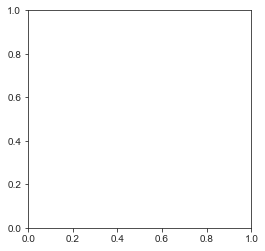

In [12]:
f,axes = plt.subplots(1,1,figsize=(4,4)) 

mi_all, mi_shuf = get_mutual_information_bootstrap(mat_data, [0,1])
# axes[beh_idx].errorbar(range(20), np.nanmean(mi_all, axis=0), yerr=np.std(mi_all, axis=0),fmt='o')
# axes[beh_idx].errorbar(range(20), np.nanmean(mi_shuf, axis=0), yerr=np.std(mi_shuf, axis=0),fmt='.')

In [ ]:
f,axes = plt.subplots(1,2,figsize=(8,4)) 

for beh_idx in range(2):
    mi_all, mi_shuf = get_mutual_information_bootstrap(mat_data, beh_idx)
    axes[beh_idx].errorbar(range(20), np.nanmean(mi_all, axis=0), yerr=np.std(mi_all, axis=0),fmt='o')
    axes[beh_idx].errorbar(range(20), np.nanmean(mi_shuf, axis=0), yerr=np.std(mi_shuf, axis=0),fmt='.')
    
#     r = [nnan_pearsonr(mat_data['x'][:,j], mat_data['y'][:,i])[0] for j in range(10)]
#     plt.plot(r)
    
#     y2 = np.array(y)
#     np.random.shuffle(y2)
    
    
#     plt.plot(mi)
#     mi = mutual_info_regression(x, y2)
#     plt.plot(mi, '--')
# fks = ['ball_pos_x_TRUE', 'ball_pos_y_TRUE', 'ball_pos_dx_TRUE', 'ball_pos_dy_TRUE',
#                     't_from_start', 't_from_occ', 't_from_end']
# plt.legend(fks)
#     mi /= np.max(mi)

# dimensionality of DMFC

In [13]:
def flatten_and_mask(x_nxcxt, mask_cxtx1):
    x_cxtxn = np.transpose(x_nxcxt, (1,2,0))
    res_x = phys_utils.flatten_to_mat(x_cxtxn, mask_cxtx1)
    return np.array(res_x['X'])

def get_flattened_masked_data(subject_id, mask_fn):
    dset = data_utils.load_neural_dataset(subject_id=subject_id)
    mask = np.expand_dims(dset['masks']['occ'][mask_fn], axis=2)
    return flatten_and_mask(dset['neural_responses_reliable']['occ'], mask)

def get_pca_res_base(x_ctxn):
    pca = PCA(n_components=None, svd_solver='full')
    tmp = pca.fit_transform(x_ctxn)
    eigen_vals = pca.explained_variance_
    exp_var = pca.explained_variance_ratio_
    pr = np.nansum(eigen_vals) ** 2 / np.nansum(eigen_vals ** 2)
    return {'pr': pr, 'exp_var': exp_var, 'eigen_vals': eigen_vals}

def shuffle_data_matrix(x):
    x_shuf = x.flatten()
    np.random.shuffle(x_shuf)
    return np.reshape(x_shuf, x.shape )

def get_pca_res(x_ctxn, nshuf=2):
    res = {}
    res['true'] = get_pca_res_base(x_ctxn)
    res['shuf'] = []

    for i in range(nshuf):
        x_ctxn_shuf = shuffle_data_matrix(x_ctxn)
        res['shuf'].append(get_pca_res_base(x_ctxn_shuf))
    return res

In [18]:
subject_id = 'all_hand_dmfc' # 'perle_hand_dmfc' # mahler_hand_dmfc50
# subject_id = 'oleo_passive_IT'
mask_fn = masks_to_test_suffix = 'start_end_pad0'
timebinsize = 50
neural_data_to_use = 'neural_responses_reliable_FactorAnalysis_50'
condition = 'occ'

figoutpath = '%s/%s%d/%s/dimensionality_%s%s/' % (figoutpath_base, subject_id, timebinsize,
                                          neural_data_to_use, masks_to_test_suffix, condition)
if not os.path.exists(figoutpath):
    os.makedirs(figoutpath)

In [19]:
x_ctxn_ = get_flattened_masked_data(subject_id, mask_fn)
res_all = get_pca_res(x_ctxn_)

res_, res_shuf_list = res_all['true'], res_all['shuf']
ndim_lehky = [np.nonzero(res_['exp_var'] <= res_shuf['exp_var'])[0][0] for res_shuf in res_shuf_list]

In [20]:
res_, res_shuf_list = res_all['true'], res_all['shuf']
# scipy.io.savemat(f, {'factor_loading':transformer_.components_}, long_field_names=True)   # append

In [21]:
print(res_['exp_var'])

[3.88584427e-01 1.43860565e-01 7.24124491e-02 ... 1.71903535e-06
 1.67002725e-06 1.62660410e-06]


In [ ]:
f,axes = plt.subplots(2,1,figsize=(5,8))
axes[0].plot(res_['exp_var'], '-o', mec='g', mfc='w', color='g')
for res_shuf in res_shuf_list:
    axes[0].plot(res_shuf['exp_var'], '-.', mec=[0.5, 0.5, 0.5], mfc='w', color=[0.5, 0.5, 0.5])
axes[0].set_xlim([-1,25])
rr_gpu.make_axis_nice(axes[0])

axes[1].plot(res_['exp_var'], '-', mec='g', mfc='w', color='g')
rr_gpu.make_axis_nice(axes[1])

f.savefig('%s/eigenvals.pdf' % figoutpath)


In [ ]:
figoutpath

In [ ]:
# ls /om/user/rishir/figs/mpong_phys/paper_scratch_202202//mahler_hand_dmfc50/neural_responses_reliable_FactorAnalysis_50/dimensionality_start_end_pad0occ/

# overlap between visible and occluded epochs


In [ ]:
dset = data_utils.load_neural_dataset(subject_id=subject_id)
mask = np.expand_dims(dset['masks']['occ'][mask_fn], axis=2)

mask_vis = np.expand_dims(dset['masks']['occ']['start_occ_pad0'], axis=2)
mask_occ = np.expand_dims(dset['masks']['occ']['occ_end_pad0'], axis=2)

neur_resp = np.array(dset['neural_responses_reliable']['occ'])

neur_resp_vis = flatten_and_mask(neur_resp, mask_vis)
neur_resp_occ = flatten_and_mask(neur_resp, mask_occ)

In [ ]:
plt.imshow(mask_occ[:,:,0])

In [ ]:
npc = 100

pca_vis = PCA(n_components=npc, svd_solver='full')
neur_resp_vis_pca = pca_vis.fit_transform(neur_resp_vis)
neur_resp_vis_pca_occ = pca_vis.transform(neur_resp_occ)

pca_occ = PCA(n_components=npc, svd_solver='full')
neur_resp_occ_pca = pca_occ.fit_transform(neur_resp_occ)
neur_resp_occ_pca_vis = pca_vis.transform(neur_resp_vis)


In [ ]:
eigen_vals = pca_vis.explained_variance_
pr = np.nansum(eigen_vals) ** 2 / np.nansum(eigen_vals ** 2)
print(pr)

eigen_vals = pca_occ.explained_variance_
pr = np.nansum(eigen_vals) ** 2 / np.nansum(eigen_vals ** 2)
print(pr)

In [ ]:
def get_exp_var_from_transformed_data(x):
    exp_var = np.nanvar(x, axis=0)
#     exp_var =  exp_var / np.sum(exp_var)
    return exp_var, np.cumsum(exp_var)
    
f,axes = plt.subplots(3,2,figsize=(10,5))
data_pairs = [
    [neur_resp_vis_pca, neur_resp_vis_pca_occ, neur_resp_occ_pca],
    [neur_resp_occ_pca, neur_resp_occ_pca_vis, neur_resp_vis_pca],
]
for di, dat_pair in enumerate(data_pairs):
    x_aa, x_ab, x_bb = dat_pair[0], dat_pair[1], dat_pair[2]
    exp_var_aa, cum_exp_var_aa = get_exp_var_from_transformed_data(x_aa)
    exp_var_ab, cum_exp_var_ab = get_exp_var_from_transformed_data(x_ab)
    exp_var_bb, cum_exp_var_bb = get_exp_var_from_transformed_data(x_bb)
    
    axes[0,di].plot(cum_exp_var_aa/np.nansum(cum_exp_var_aa))
    axes[0,di].plot(cum_exp_var_ab/np.nansum(cum_exp_var_bb))
    
    axes[1,di].plot(exp_var_aa/np.nansum(exp_var_aa))
    axes[1,di].plot(exp_var_ab/np.nansum(exp_var_bb))
    
#         axes[0,di].plot(exp_var, '-')
#         axes[1,di].plot(cum_exp_var, '-')

    
# for x in [neur_resp_occ_pca, neur_resp_occ_pca_vis]:
#     exp_var = np.nanvar(x, axis=0)
#     exp_var =  exp_var / np.sum(exp_var)
#     y = np.cumsum(exp_var)
#     axes[1].plot(y, '-o')

# axes[0].set_ylim([0,1])
# axes[1].set_ylim([0,1])


# f,axes = plt.subplots(1,2,figsize=(10,5))
# x1, x2 = neur_resp_vis_pca, neur_resp_vis_pca_occ
#     axes[0].plot(y, '-o')

    
# for x in [neur_resp_occ_pca, neur_resp_occ_pca_vis]:
#     exp_var = np.nanvar(x, axis=0)
#     exp_var =  exp_var / np.sum(exp_var)
#     y = np.cumsum(exp_var)
#     axes[1].plot(y, '-o')

# axes[0].set_ylim([0,1])
# axes[1].set_ylim([0,1])

# f,axes = plt.subplots(1,2,figsize=(10,5))
# for x in [neur_resp_vis_pca, neur_resp_vis_pca_occ]:
#     exp_var = np.nanvar(x, axis=0)
#     y = np.cumsum(exp_var)/np.sum(exp_var)
#     axes[0].plot(y, '-o')
    
# for x in [neur_resp_occ_pca, neur_resp_occ_pca_vis]:
#     exp_var = np.nanvar(x, axis=0)
#     y = np.cumsum(exp_var)/np.sum(exp_var)
#     axes[1].plot(y, '-o')





In [ ]:
neur_resp_vis_pca